In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Load dataset
data = pd.read_csv('C:/Users/RaymondCarpenter/Documents/GitHub/14thstreetanalytics/nfl-draft/qb_sheet.csv')

# Ensure all columns are numeric or convert them as needed
numeric_fields = [
    'completions', 'pass_attempts', 'completion_percentage', 'pass_yards',
    'yards_per_attempt', 'air_yards_per_attempt', 'pass_td', 'int',
    'pass_rate', 'rush_attempts', 'rush_yards', 'rush_avg', 'rush_td',
    'games_played', 'years_played'
]

for field in numeric_fields:
    data[field] = pd.to_numeric(data[field], errors='coerce')

# Normalize specified fields by 'games_played'
fields_to_normalize = [
    'completions', 'pass_attempts', 'completion_percentage', 'pass_yards',
    'yards_per_attempt', 'air_yards_per_attempt', 'pass_td', 'int',
    'pass_rate', 'rush_attempts', 'rush_yards', 'rush_avg', 'rush_td'
]

def normalize_fields(df, fields, norm_by='games_played'):
    for field in fields:
        normalized_field_name = f'{field}_per_game'
        df[normalized_field_name] = df[field] / df[norm_by]
    return df

# Apply normalization
data = normalize_fields(data, fields_to_normalize)

# Define features for similarity comparison, including normalized fields
features = [f'{field}_per_game' for field in fields_to_normalize] + ['games_played', 'years_played']

# Separate datasets
data_2024 = data[data['draft_class'] == 2024]
data_not_2024 = data[data['draft_class'] != 2024]

# Function to clean and prepare dataset (assuming the data is already numeric)
def clean_and_prepare_dataset(df, column_names):
    # Fill missing values with the mean of each column
    df_filled = df[column_names].fillna(df[column_names].mean(), inplace=False)
    return df_filled

# Prepare datasets
data_2024_prepared = clean_and_prepare_dataset(data_2024, features)
data_not_2024_prepared = clean_and_prepare_dataset(data_not_2024, features)

# Normalize the feature values using StandardScaler
scaler = StandardScaler()
data_2024_scaled = scaler.fit_transform(data_2024_prepared)
data_not_2024_scaled = scaler.transform(data_not_2024_prepared)

# Calculate cosine similarity between the 2024 prospects and other quarterbacks
similarity = cosine_similarity(data_2024_scaled, data_not_2024_scaled)

# Convert the similarity matrix to a DataFrame for easier manipulation
similarity_df = pd.DataFrame(similarity, index=data_2024['name'], columns=data_not_2024['name'])

# Find the most similar quarterback for each 2024 prospect
most_similar_qbs = {name: similarity_df.loc[name].idxmax() for name in similarity_df.index}

# Print the results
for prospect, similar_qb in most_similar_qbs.items():
    print(f"{prospect} is most similar to {similar_qb}.")

Devin Leary is most similar to Rusty Smith.
Michael Penix is most similar to Landry Jones.
Spencer Rattler is most similar to Shane Carden.
J.J. McCarthy is most similar to Nathan Peterman.
Joe Milton III is most similar to Carson Wentz.
Caleb Williams is most similar to Trevor Lawrence.
Sam Hartman is most similar to Kenny Pickett.
Michael Pratt is most similar to Trace McSorley.
Drake Maye is most similar to DeShone Kizer.
Bo Nix is most similar to Kenny Pickett.
Jordan Travis is most similar to D'Eriq King.
Jayden Daniels is most similar to Colin Kaepernick.


In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Load dataset
data = pd.read_csv('C:/Users/RaymondCarpenter/Documents/GitHub/14thstreetanalytics/nfl-draft/qb_sheet.csv')

# Fields to normalize by 'games_played' and fields used directly
fields_to_normalize = [
    'Cmp', 'Att', 'Yds', 'TD', 'Int',
    'Rush Att', 'Rush Yds', 'Rush TD'
]
fields_not_normalized = [
    'Cmp%', 'Y/A', 'AY/A',
    'Pass Rate', 'Rush Avg', 'Height', 'Weight'
]

# Ensure all columns are numeric or convert them as needed
for field in fields_to_normalize + fields_not_normalized + ['GP', 'YP']:
    data[field] = pd.to_numeric(data[field], errors='coerce')

def normalize_fields(df, fields_to_normalize, norm_by='GP'):
    for field in fields_to_normalize:
        df[field + ' Per Game'] = df[field] / df[norm_by]
    return df

# Apply normalization
data = normalize_fields(data, fields_to_normalize)

# Prepare the features list for similarity comparison
features_normalized = [f'{field} Per Game' for field in fields_to_normalize]
features = features_normalized + fields_not_normalized + ['GP', 'YP']

# Add cumulative stats to the features list for comparison
features += fields_to_normalize

# Fill missing values with the mean of each column
data_filled = data[features].fillna(data[features].mean(), inplace=False)

# Separate datasets
data_2024 = data[data['draft_class'] == 2024]
data_not_2024 = data[data['draft_class'] != 2024]

# Normalize the feature values using StandardScaler
scaler = StandardScaler()
data_2024_scaled = scaler.fit_transform(data_filled.loc[data_2024.index])
data_not_2024_scaled = scaler.transform(data_filled.loc[data_not_2024.index])

# Calculate cosine similarity
similarity = cosine_similarity(data_2024_scaled, data_not_2024_scaled)

# Input for a specific 2024 player's name
player_name = input("Enter the name of the 2024 player to compare: ")

try:
    player_index = data_2024[data_2024['name'].str.lower() == player_name.lower()].index[0]
    similarity_scores = similarity[player_index - data_2024.index[0]]
    most_similar_index = similarity_scores.argmax()
    most_similar_player_name = data_not_2024.iloc[most_similar_index]['name']
    percentage_similarity = (similarity_scores[most_similar_index] + 1) / 2 * 100

    print(f"\nThe most similar player to {player_name} is {most_similar_player_name} with {percentage_similarity:.2f}% similarity.\n")

    # Gather stats for comparison
    player_stats = data_filled.loc[data_2024.index][features].iloc[player_index - data_2024.index[0]]
    similar_player_stats = data_filled.loc[data_not_2024.index][features].iloc[most_similar_index]

    comparison_df = pd.DataFrame({
        player_name: player_stats.values,
        most_similar_player_name: similar_player_stats.values
    }, index=features)
    
    print(comparison_df)
except IndexError:
    print("Player not found in the 2024 draft class. Please check the name and try again.")



The most similar player to Caleb Williams is Sam Howell with 92.25% similarity.

                   Caleb Williams    Sam Howell
Cmp Per Game            19.864865     19.270270
Att Per Game            29.702703     30.189189
Yds Per Game           272.486486    277.918919
TD Per Game              2.513514      2.486486
Int Per Game             0.378378      0.621622
Rush Att Per Game        7.810811      9.972973
Rush Yds Per Game       26.108108     27.270270
Rush TD Per Game         0.729730      0.459459
Cmp%                    66.900000     63.800000
Y/A                      9.200000      9.200000
AY/A                    10.300000      9.900000
Pass Rate              169.300000    164.200000
Rush Avg                 3.300000      2.700000
Height                  73.000000     73.000000
Weight                 214.000000    218.000000
GP                      37.000000     37.000000
YP                       3.000000      3.000000
Cmp                    735.000000    713.000000
Att   

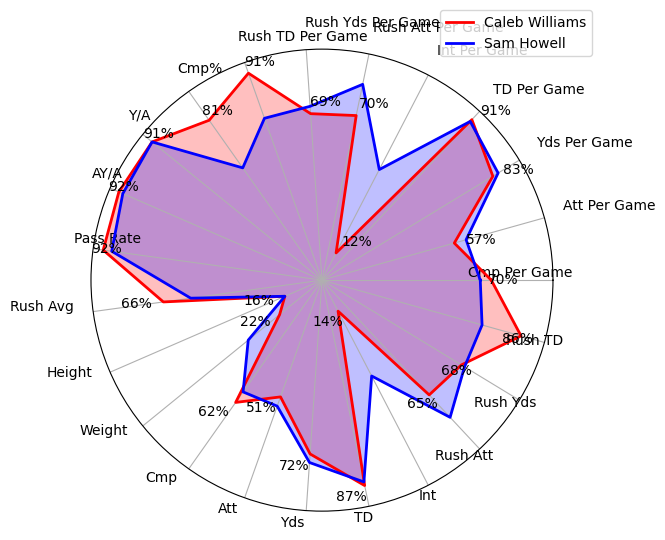

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from math import pi

# Calculate percentiles for the dataset
def calculate_percentiles(df, features):
    for feature in features:
        percentile_col_name = f'{feature}_percentile'
        df[percentile_col_name] = df[feature].rank(pct=True)
    return df

data_filled = calculate_percentiles(data_filled, features)

# Separate datasets for 2024 and not 2024
data_2024 = data[data['draft_class'] == 2024]
data_not_2024 = data[data['draft_class'] != 2024]

# Normalize the feature values using StandardScaler
scaler = StandardScaler()
features_to_scale = features_normalized + fields_not_normalized + ['GP', 'YP'] + fields_to_normalize
data_filled_scaled = scaler.fit_transform(data_filled[features_to_scale])
data_filled[features_to_scale] = data_filled_scaled

data_2024_scaled = data_filled.loc[data_2024.index]
data_not_2024_scaled = data_filled.loc[data_not_2024.index]

# Calculate cosine similarity
similarity = cosine_similarity(data_2024_scaled[features_to_scale], data_not_2024_scaled[features_to_scale])

player_name = input("Enter the name of the 2024 player to compare: ")

try:
    player_index = data_2024[data_2024['name'].str.lower() == player_name.lower()].index[0]
    similarity_scores = similarity[player_index - data_2024.index[0]]
    most_similar_index = similarity_scores.argmax()
    most_similar_player_name = data_not_2024.iloc[most_similar_index]['name']
    
    # Exclude 'games_played' and 'years_played' from percentile features for radar chart
    features_for_radar = [feature for feature in features if feature not in ['GP', 'YP']]
    percentile_features = [f'{feature}_percentile' for feature in features_for_radar]
    
    player_percentiles = data_filled.loc[player_index, percentile_features]
    similar_player_percentiles = data_filled.loc[data_not_2024.index[most_similar_index], percentile_features]

    # Radar Chart
    labels = np.array(features_for_radar)
    num_vars = len(labels)
    
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop
    
    player_stats = player_percentiles.tolist() + player_percentiles.tolist()[:1]
    similar_player_stats = similar_player_percentiles.tolist() + similar_player_percentiles.tolist()[:1]
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, player_stats, color='red', alpha=0.25)
    ax.fill(angles, similar_player_stats, color='blue', alpha=0.25)
    ax.plot(angles, player_stats, color='red', linewidth=2, label=player_name)
    ax.plot(angles, similar_player_stats, color='blue', linewidth=2, label=most_similar_player_name)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, rotation=45, ha="right")

    # Remove specific measurement lines
    ax.set_yticks([])  # This removes all radial gridlines

    # Adding number labels for percentiles as before
    for label, angle, stat in zip(labels, angles[:-1], player_stats[:-1]):
        if angle in (0, pi):
            ha = 'center'
        elif 0 < angle < pi:
            ha = 'left'
        else:
            ha = 'right'
        ax.text(angle, stat + 0.05, f"{int(stat*100)}%", size=10, horizontalalignment=ha, verticalalignment="center")

    # Ensure label names are outside
    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        if angle in (0, pi):
            label.set_verticalalignment("bottom")
        elif 0 < angle < pi:
            label.set_verticalalignment("bottom")
            label.set_horizontalalignment("left")
        else:
            label.set_verticalalignment("bottom")
            label.set_horizontalalignment("right")

    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()

except IndexError:
    print("Player not found in the 2024 draft class. Please check the name and try again.")


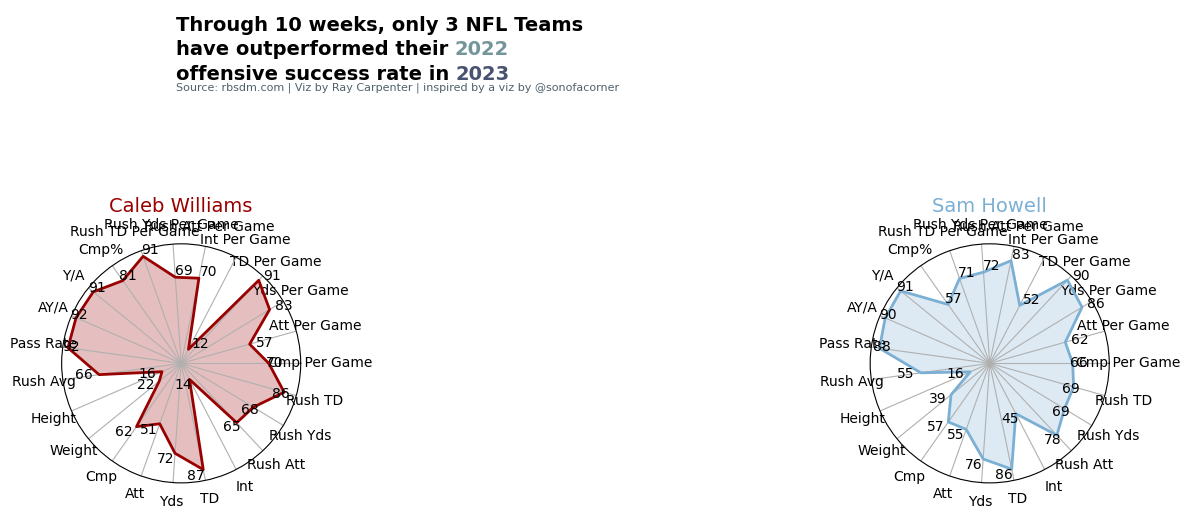

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from highlight_text import fig_text

def make_radar_chart(name, stats, feature_names, ax, fill_color, line_color):
    # Number of variables we're plotting.
    num_vars = len(feature_names)

    # Split the circle into even parts and save the angles.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Complete the loop.
    stats += stats[:1]
    angles += angles[:1]

    # Plot data.
    ax.fill(angles, stats, color=fill_color, alpha=0.25)
    ax.plot(angles, stats, color=line_color, linewidth=2)

    # Beautify the plot.
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_names)

    # Set the player name as the title.
    ax.set_title(name, size=14, color=line_color, y=1.1)

    # Adding number labels for percentiles without "%" symbol.
    for label, angle, stat in zip(feature_names, angles[:-1], stats[:-1]):
        if angle in (0, pi):
            ha = 'center'
        elif 0 < angle < pi:
            ha = 'left'
        else:
            ha = 'right'
        ax.text(angle, stat + 0.05, f"{int(stat*100)}", size=10, horizontalalignment=ha, verticalalignment="center")
    ax.set_yticks([])  # Removes all radial gridlines.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(polar=True))
fig_text(
    x = 0.15, y = .9, 
    s = "Through 10 weeks, only 3 NFL Teams\nhave outperformed their <2022> \noffensive success rate in <2023>",
    highlight_textprops = [
        {"color":"#74959A"},
        {"color": "#495371"}
    ],
    va = "bottom", ha = "left",
    fontsize = 14, color = "black", weight = "bold"
)
fig_text(
	x = 0.15, y = .885, 
    s = "Source: rbsdm.com | Viz by Ray Carpenter | inspired by a viz by @sonofacorner",
	va = "bottom", ha = "left",
	fontsize = 8, color = "#4E616C"
)
# Update these lines with your actual data and colors.
player_color = '#990000'  # Change as needed.
similar_player_color = '#7BAFD4'  # Change as needed.
make_radar_chart(player_name, player_percentiles.tolist(), labels, ax1, fill_color=player_color, line_color=player_color)
make_radar_chart(most_similar_player_name, similar_player_percentiles.tolist(), labels, ax2, fill_color=similar_player_color, line_color=similar_player_color)

plt.tight_layout()
plt.show()
